In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import os
import re
import math
from tqdm import tqdm
from itertools import compress
import scipy.integrate as integrate
import math

In [2]:
def createPressureGrid(h1Data):
    hyam = np.array(h1Data["hyam"])
    hybm = np.array(h1Data["hybm"])
    ps = np.array(h1Data["NNPS"])
    lats = np.array(h1Data["lat"])
    lons = np.array(h1Data["lon"])
    levs = hyam[0]
    times = np.array(range(len(ps)))
    pressureGrid = np.zeros([len(times), len(levs), len(lats), len(lons)])
    for t in range(len(times)):
        for lat in range(len(lats)):
            for lon in range(len(lons)):
                pressureGrid[t, :, lat, lon]  = hyam[t]*1e5 + ps[t][lat][lon]*hybm[t]
    return np.diff(pressureGrid, axis = 1)

r = 6371
def integrand(t):
    return math.sin(t)

def surfArea(lat1, lat2, lon1, lon2):
    lat1 = lat1 + 90
    lat2 = lat2 + 90
    lat1 = min(lat1,lat2)*math.pi/180
    lat2 = max(lat1, lat2)*math.pi/180
    lons = (max(lon1, lon2) - min(lon1, lon2))*math.pi/180
    a = integrate.quad(integrand, lat1, lat2)
    #max error is 2nd arg for a
    return lons*r*r*a[0]

# Longitudes are equidistant so we can simplify surfArea
def weight_area(lat1, lat2):
    lat1 = lat1 + 90
    lat2 = lat2 + 90
    lat1 = min(lat1,lat2)*math.pi/180
    lat2 = max(lat1, lat2)*math.pi/180
    weight = integrate.quad(integrand, lat1, lat2)
    return weight[0]

In [3]:
spPath = "/ocean/projects/atm200007p/jlin96/prognosticTesting/coupledResults/spcamTrim/"
spList = os.popen(" ".join(["ls", spPath + "*.h1.0000*"])).read().splitlines()
spData = xr.open_mfdataset(spList)
spTemp = np.array(spData["NNTBP"].groupby("time.month").mean("time"))
spHum = np.array(spData["NNQBP"].groupby("time.month").mean("time"))

In [4]:
lagPath = "/ocean/projects/atm200007p/jlin96/prognosticTesting/coupledResults/spcamLag/"
lagList = os.popen(" ".join(["ls", lagPath + "*.h1.000*"])).read().splitlines()
lagData = xr.open_mfdataset(lagList)
lagTemp = np.array(lagData["NNTBP"][10:-1].groupby("time.month").mean("time"))
lagHum = np.array(lagData["NNQBP"][10:-1].groupby("time.month").mean("time"))

In [5]:
# AREA WEIGHTING

lats = np.array(spData["lat"])
assert(90+lats[0]==90-lats[63])
last_lat_mdiff = 90+lats[0]
lat_mdiff = np.diff(lats)/2
lat_buff = np.append(lat_mdiff, last_lat_mdiff)
lat_edges = lat_buff + lats
lat_edges = np.append(-90, lat_edges)
area_weights = []
for i in range(len(lats)):
    area_weights.append(weight_area(lat_edges[i],lat_edges[i+1]))
area_weights = np.array(area_weights)
area_weights = area_weights[np.newaxis,:,np.newaxis]

# MASS WEIGHTING

pressures = np.mean(createPressureGrid(spData), axis = 0)[11:29]
error_weights = area_weights * pressures
error_weights = error_weights/sum(error_weights.flatten())
error_weights = error_weights[np.newaxis, :]


In [6]:
sum(error_weights.flatten())

1.0000000000000069

In [7]:
error_weights.shape

(1, 18, 64, 8)

In [8]:
spData["NNTBP"][:,12:30,:,:].shape

(365, 18, 64, 8)

In [9]:
laggedTemp = (lagTemp[:,12:30,:,:] - spTemp[:,12:30,:,:])**2
laggedTemp = error_weights*laggedTemp
laggedTemp = np.sum(laggedTemp, axis = (1,2,3))**.5

laggedHum = (lagHum[:,12:30,:,:] - spHum[:,12:30,:,:])**2
laggedHum = error_weights*laggedHum
laggedHum = np.sum(laggedHum, axis = (1,2,3))**.5

In [10]:
lat = np.array(spData["lat"])
lon = np.array(spData["lon"])
lev = np.array(spData["lev"])

In [11]:
#this is to ignore months that aren't completed
month_length = np.array([len(spData.groupby("time.month")[x]["time"]) for x in np.array(range(12))+1])
month_sum = np.cumsum(month_length)

def peek(family, number, var):
    folder = "/ocean/projects/atm200007p/jlin96/prognosticTesting/coupledResults/" + family + "_long/"
    path = folder + family + "Model%04d"%number + "/"
    h1List = os.popen(" ".join(["ls", path + "*.h1.0000*"])).read().splitlines()
    dataset = xr.open_mfdataset(h1List)
    if var == "NNTBP":
        arr = dataset["NNTBP"]
    elif var == "NNQBP":
        arr = dataset["NNQBP"]
    return arr

def getDiff(family, number, var):
    arr = peek(family, number, var)
    endLength = np.arange(1,13)[arr.shape[0]>=month_sum][-1] #such that only complete months are added
    arr = np.array(arr.groupby("time.month").mean("time"))
    if var == "NNTBP":
        sp_vals = spTemp[:endLength,12:30,:,:]
    elif var == "NNQBP":
        sp_vals = spHum[:endLength,12:30,:,:]
    se = (sp_vals-arr[:endLength,12:30,:,:])**2
    wse = error_weights*se
    return np.sum(wse, axis = (1,2,3))**.5

def monthcheck(family, number, var):
    arr = peek(family, number, var)
    if arr.shape[0] < 31:
        return False
    return True

In [13]:
relative_long_diff_T = []
relative_long_diff_Q = []

specific_long_diff_T = []
specific_long_diff_Q = []

for i in tqdm(range(400)):
    
    modelrank = i+1
    
    if monthcheck("relative", modelrank, "NNTBP"):
        relative_long_diff_T.append(getDiff("relative", modelrank, "NNTBP"))
    if monthcheck("relative", modelrank, "NNQBP"):
        relative_long_diff_Q.append(getDiff("relative", modelrank, "NNQBP"))
    
    if monthcheck("specific", modelrank, "NNTBP"):
        specific_long_diff_T.append(getDiff("specific", modelrank, "NNTBP"))
    if monthcheck("specific", modelrank, "NNQBP"):
        specific_long_diff_Q.append(getDiff("specific", modelrank, "NNQBP"))
    
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [04:10<00:00,  1.59it/s]


In [14]:
def plotDiffs(axnum, families, var):
    color = "red"
    for family in families:   
        for i in range(len(family)):
            axnum.plot(family[i], color = color)
        color = "blue"
    color = "black"
    if var == "NNTBP":
        axnum.plot(laggedTemp, color = color)
    if var == "NNQBP":
        axnum.plot(laggedHum, color = color)
    red_patch = mpatches.Patch(facecolor='red') 
    blue_patch = mpatches.Patch(facecolor='blue')
    black_patch = mpatches.Patch(facecolor='black')
    #black_patch = mpatches.Patch(facecolor='black')
    #plt.plot(lagDiff, color = "black")
    axnum.legend(handles = [red_patch, blue_patch, black_patch], \
               labels=["relative", "specific", "IV proxy"], \
               loc="upper right", \
               borderaxespad=0.1)
    axnum.set_yscale("log")
    axnum.set_title(var + " RMSE")

    axnum.set_xlabel("month")
    if var == "NNTBP":
        axnum.set_ylabel("K")
    if var == "NNQBP":
        axnum.set_ylabel("kg/kg")

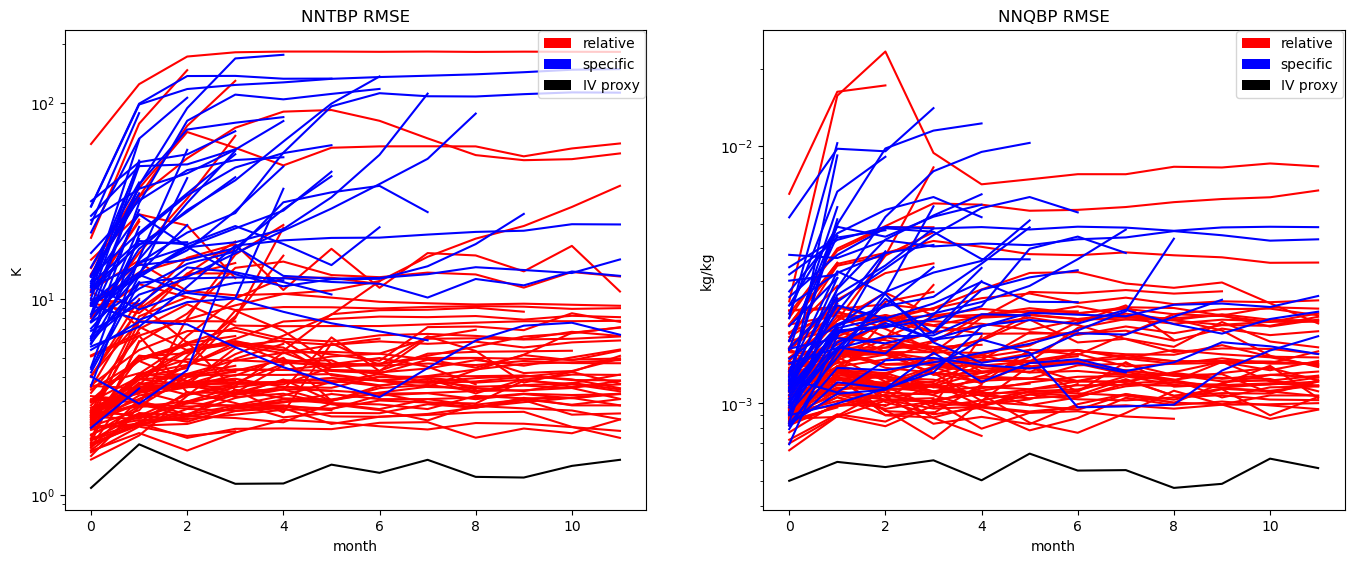

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax1 = ax[0]
ax2 = ax[1]


plotDiffs(ax1, [relative_long_diff_T, specific_long_diff_T], "NNTBP")


plotDiffs(ax2, [relative_long_diff_Q, specific_long_diff_Q], "NNQBP")



plt.subplots_adjust(0,0,2,1)

In [47]:
def plotDiffs_retrain(axnum, families, var, relative = False):
    color = "green"
    for family in families:   
        for i in range(len(family)):
            axnum.plot(family[i], color = color)
        color = "orange"
    color = "black"
    if var == "NNTBP":
        axnum.plot(laggedTemp, color = color)
    if var == "NNQBP":
        axnum.plot(laggedHum, color = color)
    green_patch = mpatches.Patch(facecolor='green') 
    orange_patch = mpatches.Patch(facecolor='orange')
    black_patch = mpatches.Patch(facecolor='black')
    #plt.plot(lagDiff, color = "black")
    axnum.legend(handles = [green_patch, orange_patch, black_patch], \
               labels=["before retraining", "after retraining", "IV proxy"], \
               loc="upper right", \
               borderaxespad=0.1)
    axnum.set_yscale("log")
    if relative:
        axnum.set_title(var + " RMSE (relative)")
    else:
        axnum.set_title(var + " RMSE (specific)")
    axnum.set_xlabel("day")
    if var == "NNTBP":
        axnum.set_ylabel("K")
    if var == "NNQBP":
        axnum.set_ylabel("kg/kg")

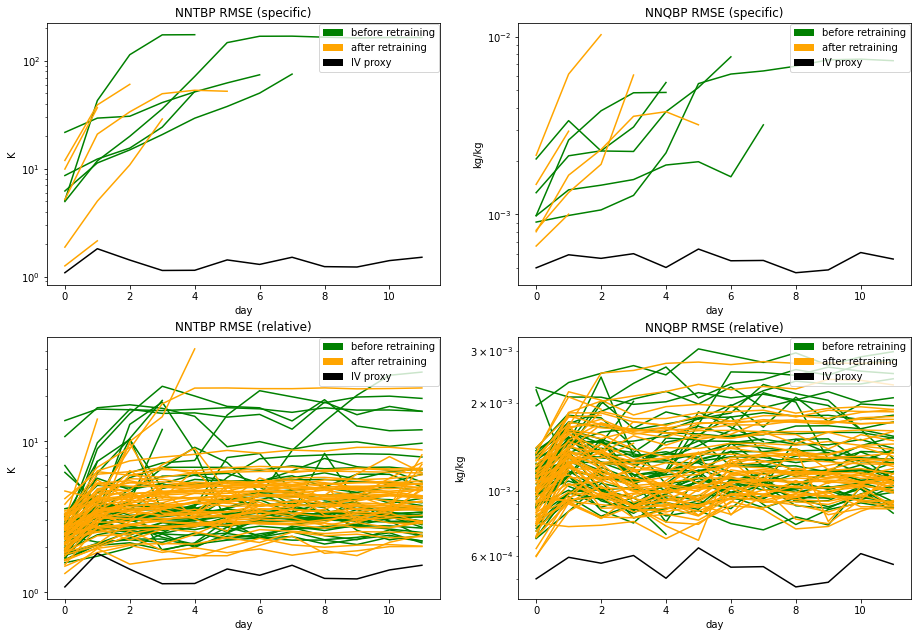

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=2)

ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1]

plotDiffs_retrain(ax1, [specific_trim_diff_T, specific_retrain_diff_T], "NNTBP", relative = False)
plotDiffs_retrain(ax2, [specific_trim_diff_Q, specific_retrain_diff_Q], "NNQBP", relative = False)
plotDiffs_retrain(ax3, [relative_trim_diff_T, relative_retrain_diff_T], "NNTBP", relative = True)
plotDiffs_retrain(ax4, [relative_trim_diff_Q, relative_retrain_diff_Q], "NNQBP", relative = True)


plt.subplots_adjust(0,0,2,2)